In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import model_HIVandSTI
from tapm import utils
import icomo
import diffrax
import numpy as np

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


In [2]:
#output = integrator(y0=y0, constant_args=args)
output = icomo.diffeqsolve(
    args = model_HIVandSTI.args,
    ODE = model_HIVandSTI.main_model,
    y0 = model_HIVandSTI.y0,
    ts_out = np.linspace(0, 365*80, 365*80+1),
    max_steps=365*80+1)

INFO:tapm.HIVandSTI.model_HIVandSTI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.model_HIVandSTI:Parameters: m_min = 0.0, m_max = 1


A1 [21.56734517 18.97910595  7.55026671 12.24228218]
A2 [1418.06558237 1235.9365626   487.11760631  198.9111044 ]
A3 [82.00645021 71.50956956 28.19744412 11.19889834]
A4 [103.1004496   89.88725729  35.43631832  13.96662222]
D [4635.82945191 3845.17953217 1448.53214915  723.36548731]
D_STI [4635.82945191 3845.17953217 1448.53214915  723.36548731]
I1 [11.16899706  9.82352235  3.90988018  1.18476303]
I2 [311.44772477 272.65785395 107.96095583  38.39461129]
I3 [33.91733245 29.67684273 11.74328048  4.23855416]
I4 [30.10201173 26.31886181 10.40584409  3.82252005]
IP [257.99529272 216.51452181  82.71911006   0.60618359]
Ia_STI [51578.77662248 38987.70108276 13105.66476175  7545.8403236 ]
Is_STI [345.59025651 262.47895103  89.508428    53.85071221]
S [81237.30278479 63187.68359649 22217.38021547  5353.33934735]
SP [6567.49657722 5125.83277329 1809.04692928 8548.72962608]
S_STI [37762.23098149 30737.41115344 11501.96564449  6518.78732857]
T_STI [387.57268761 297.22928059 104.32901661  68.156148

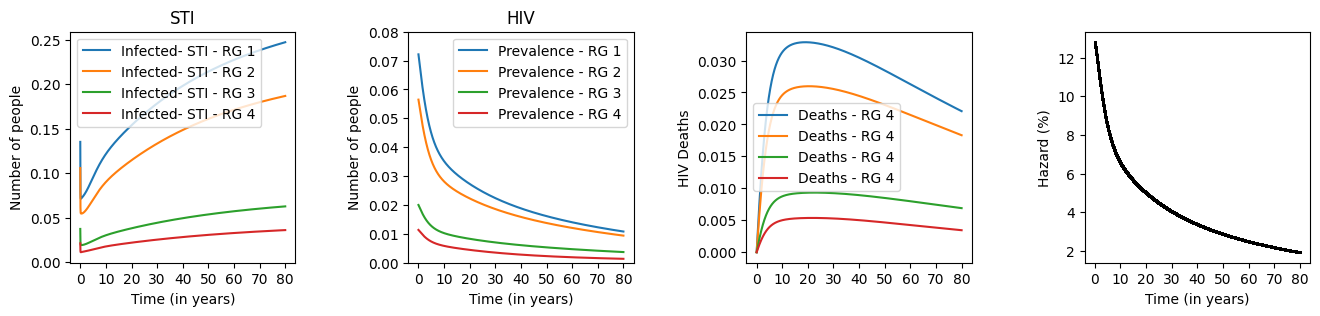

In [3]:

fig, axes = plt.subplots(1, 4, figsize=(16,3))
fig.subplots_adjust(wspace=0.5)

def number_of_people(comps, risk_group):
    total = 0
    for comp in comps:
        total += output.ys[comp][:,risk_group]
    return total

# STI
ax = axes[0]
for i in range(output.ys["Is_STI"].shape[1]):
    ax.plot(number_of_people(comps=("Is_STI", "Ia_STI"), risk_group=i), label="Infected- STI - RG "+str(i+1))

ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
#ax.set_ylim(0, 0.1)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("STI")
ax.legend()

# HIV
ax = axes[1]
# ART per risk group
#for i in range(output.ys["A1"].shape[1]): # go through all risk groups
#    ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4"), risk_group=i), label="ART - RG "+str(i+1)) # add all disease stages together

# I per risk group 
#for i in range(output.ys["I1"].shape[1]):
#    ax.plot(number_of_people(comps=("IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Infected - RG "+str(i+1))

# ART and I per risk group = Prevalence
for i in range(output.ys["I1"].shape[1]):
    ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4", "IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Prevalence - RG "+str(i+1))


ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
ax.set_ylim(0, 0.08)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("HIV")
ax.legend()

# HIV deaths
ax = axes[2]
ax.plot(output.ys["D"], label="Deaths - RG "+str(i+1))
ax.legend()
ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
ax.set_ylabel("HIV Deaths")

# hazard
ax = axes[3]
all_ART_keys = ["A1","A2","A3","A4"]
all_HIV_keys = ["S","SP","I1","I2","I3","I4","IP"] + all_ART_keys
all_STI_keys = ["S_STI","Ia_STI","Is_STI","T_STI"]
sum_vector = 0
compartment_matrix = 0
for i in range(output.ys["A1"].shape[1]):
    sum_vector += jnp.sum(jnp.array([output.ys[k][:,i] for k in all_HIV_keys]), axis=0)

for i in range(output.ys["A1"].shape[1]):
    compartment_matrix += jnp.sum(jnp.array([output.ys[key][:,i] for key in all_ART_keys]), axis=0)  # Shape: (len(all_ART_keys), time_points)
hazard_vector = compartment_matrix / sum_vector * 100   # Vectorized hazard computation

ax.scatter(range(len(hazard_vector)), hazard_vector, color="black", s=1)

ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
ax.set_ylabel("Hazard (%)")
ax.set_xlabel("Time (in years)")

# print for each compartment in output the last time value
HIV_sum_at_end = [0,0,0,0]
STI_sum_at_end = [0,0,0,0]
HIV_sum_at_start = [0,0,0,0]
STI_sum_at_start = [0,0,0,0]

for key, value in output.ys.items():
    print(key, value[-1]*210000)

for key in (all_HIV_keys + ["D"]):
    for i in range(4):
        HIV_sum_at_end[i] += output.ys[key][-1,i]
        HIV_sum_at_start[i] += output.ys[key][0,i]
for key in (all_STI_keys + ["D_STI"]):
    for i in range(4):
        STI_sum_at_end[i] += output.ys[key][-1,i]
        STI_sum_at_start[i] += output.ys[key][0,i]
print("HIV sum at start", HIV_sum_at_start)
print("STI sum at start", STI_sum_at_start)
print("HIV sum at end", HIV_sum_at_end)
print("STI sum at end", STI_sum_at_end)